## Imports

In [4]:
!pip install rasterio

In [69]:
import os
import sys
import time
import math
import random
import warnings
from glob import glob
from datetime import datetime
from collections import defaultdict, Counter
from math import cos, pi

import random
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode

import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, mode
from scipy.ndimage import morphology
from scipy.ndimage.filters import maximum_filter1d

from scipy.stats import skew, kurtosis
import numpy as np


import tifffile
import rasterio
from rasterio.plot import show

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode, ToTensor

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    jaccard_score, accuracy_score, confusion_matrix
)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from tqdm import tqdm

warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
def parse_crop_windows(filepath):
    """
    Reads a classes25pc.txt file of the form:
      2|Other cereals|20171109|20180630
      1,3,5,...|Unk cropland|20180201|20181230
    Returns:
      windows: dict[int, (start_md:int, end_md:int)]
    """
    windows = {}
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            ids_str, _, start_str, end_str = line.split('|')
            start_md = int(start_str[4:])   # e.g. '20180115' → 0115 → 115
            end_md   = int(end_str[4:])
            for orig_id in map(int, ids_str.split(',')):
                windows[orig_id] = (start_md, end_md)
    return windows


def parse_date_from_filename(filename):
    """
    Expects a basename like '20180508.tif' (YYYYMMDD.tif)
    Returns a datetime.date
    """
    date_str = os.path.basename(filename).split('.')[0]
    return datetime.strptime(date_str, '%Y%m%d').date()

In [38]:
def relabel_mask(y, date, windows, label_remap, unknown_label=4):

    """
    y            : 2D array of original class IDs
    date         : datetime.date of the image
    windows      : dict[orig_id] → (start_md, end_md)
    label_remap  : dict[orig_id] → new_id
    unknown_label: what to assign when outside window or unmapped
    Returns a new 2D mask with values in {0…N_classes-1}
    """
    md = date.month * 100 + date.day   # → MMDD (e.g., 1109)
    y_flat = y.flatten()
    y_new = np.empty_like(y_flat)
    
    for idx, orig in enumerate(y_flat):
        base = label_remap.get(orig, unknown_label)
        start_end = windows.get(orig)
        
        if start_end:
            start_md, end_md = start_end
            if start_md <= end_md:
                # Normal window (e.g., 0301–1001)
                in_window = start_md <= md <= end_md
            else:
                # Cross-year window (e.g., 1109–0630)
                in_window = (md >= start_md or md <= end_md)
            if not in_window:
                base = unknown_label
        else:
            base = unknown_label
        
        y_new[idx] = base
    
    return y_new.reshape(y.shape)



In [8]:

def load_image(path):
    """Returns a (bands, H, W) float32 ndarray from a .tif"""
    with rasterio.open(path) as src:
        return src.read().astype(np.float32)

def load_mask(tile_dir):
    """Loads the annual ground‐truth y.tif in that tile folder"""
    mask_path = os.path.join(tile_dir, 'y.tif')
    with rasterio.open(mask_path) as src:
        return src.read(1).astype(np.int32)


In [50]:
def load_all_data(
    base_path,
    folders,
    years,
    classes_txt,
    label_remap,
    img_size=(48,48),
    bands=9,
    test_size=0.2,
    max_per_group=None, #grp: region/year ie. *6  
):
    # parse windows
    windows = parse_crop_windows(classes_txt)
    
    all_data    = []
    band_sums   = np.zeros(bands, dtype=np.float64)
    band_sqsums = np.zeros(bands, dtype=np.float64)
    band_counts = np.zeros(bands, dtype=np.int64)
    
    for region in folders:
        for year in years:
            bar = tqdm(
                total=max_per_group,
                desc= region+" "+year,
                unit="img",
                leave=True,              # leave completed bar only if desired
                dynamic_ncols=True,      # auto-width
                position=0,              # ← ensures reuse of the same line
                ncols=100
            )
            
            group_count = 0
            tiles_root  = os.path.join(base_path, region, year)
            
            for tile_id in sorted(os.listdir(tiles_root)):
                if max_per_group is not None and group_count >= max_per_group:
                    break
                tile_dir = os.path.join(tiles_root, tile_id)
                if not os.path.isdir(tile_dir):
                    continue
                
                y_tile = load_mask(tile_dir)
                
                for fname in sorted(os.listdir(tile_dir)):
                    if max_per_group is not None and group_count >= max_per_group:
                        break
                    if not fname.endswith('.tif') or '_MSAVI' in fname or fname == 'y.tif':
                        continue
                    
                    img_path = os.path.join(tile_dir, fname)
                    date     = parse_date_from_filename(fname)
                    X_img    = load_image(img_path)
                    y_img    = relabel_mask(y_tile, date, windows, label_remap)
                    
                    # accumulate stats
                    for b in range(bands):
                        band = X_img[b].astype(np.float64)
                        band_sums[b]   += band.sum()
                        band_sqsums[b] += (band**2).sum()
                        band_counts[b] += band.size
                    
                    all_data.append((X_img, y_img))
                    group_count += 1
                    bar.update(1)
            
            bar.close()
    
    # compute means/stds
    means = band_sums / band_counts
    stds  = np.sqrt(band_sqsums / band_counts - means**2)

    
    return all_data, means, stds


In [51]:
BASE_PATH    = '/kaggle/input/sentinel2-crop-mapping'
FOLDERS      = ['lombardia','lombardia2']
YEARS        = ['data2016','data2017','data2018']
CLASSES_TXT  = '/kaggle/input/sentinel2-crop-mapping/lombardia-classes/classes25pc.txt'

label_remap = {
    2: 0,  # Cereals
    9: 1,  # Maize
    12: 2, # Rice
    7: 3,  # Forage
    1: 4, 3: 4, 5: 4, 6: 4, 8: 4, 10: 4, 11: 4, 13: 4, 14: 4, 15: 4, 16: 4, 19: 4, 255:4,  # Unknown crop
    4: 5,  # Woods/tree crops
    17: 6, 18: 6, 20: 6, 21: 6,  # Non-agricultural
}

#loading all data
all_data, means, stds = load_all_data(
    BASE_PATH,
    FOLDERS,
    YEARS,
    CLASSES_TXT,
    label_remap,
    max_per_group=400
)


print(f" Loaded {len(train_data)} train and {len(val_data)} val samples")
print("Per-band means:", np.round(means,2))
print("Per-band stds: ", np.round(stds,2))


lombardia2 data2018: 100%|██████████| 400/400 [00:04<00:00, 88.21img/s]

 Loaded 1920 train and 480 val samples
Per-band means: [2938.5  3004.29 2959.38 3334.02 3919.47 4174.36 4286.54 2883.44 2225.22]
Per-band stds:  [3521.42 3244.4  3155.23 3107.06 2684.03 2563.14 2607.29 1526.83 1406.23]



📦 Sample 0, Shape: (9, 48, 48)
Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt
   0 | 8977.92   74.05 8746.00 9207.00 8923.00 8976.00 9024.00    0.23   -0.27
   1 | 9119.96   70.96 8936.00 9341.00 9065.00 9116.00 9166.00    0.24   -0.45
   2 | 9212.41   73.81 8983.00 9419.00 9158.00 9210.00 9270.25    0.01   -0.62
   3 | 9844.41   74.83 9667.00 10005.00 9789.50 9841.00 9904.00    0.02   -0.79
   4 | 9603.38   72.69 9429.00 9770.00 9546.00 9599.00 9667.00    0.03   -0.86
   5 | 9434.58   71.28 9223.00 9573.00 9379.00 9432.00 9496.00   -0.14   -0.84
   6 | 9874.52   74.52 9666.00 10114.00 9818.00 9872.00 9925.00    0.21   -0.42
   7 | 2012.05   35.56 1941.00 2114.00 1986.00 2006.00 2035.00    0.68   -0.16
   8 | 2457.07   28.98 2385.00 2543.00 2435.00 2454.00 2478.00    0.29   -0.54


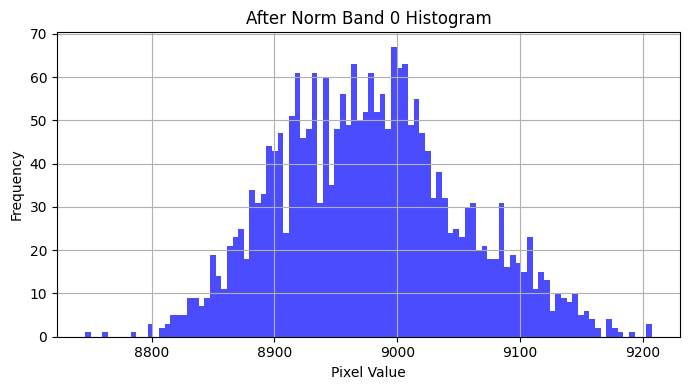

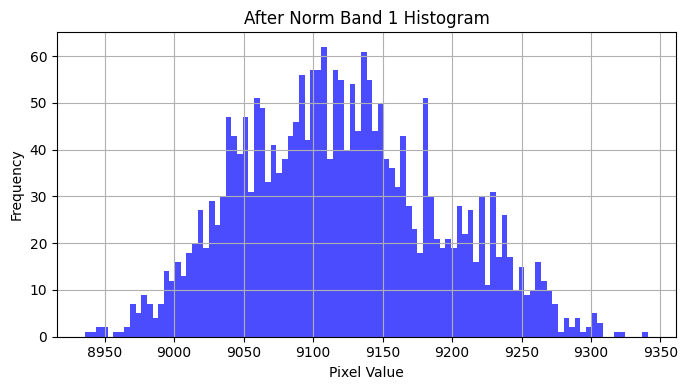

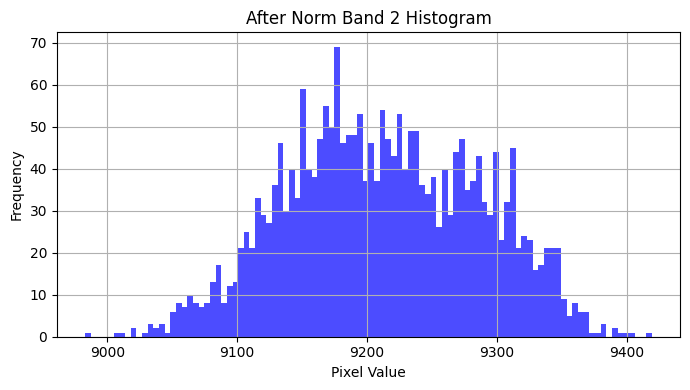

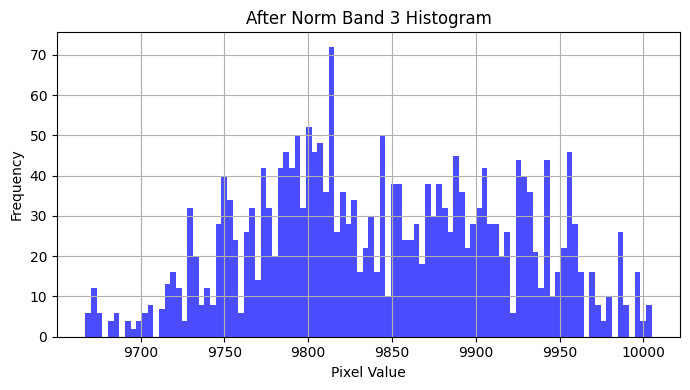

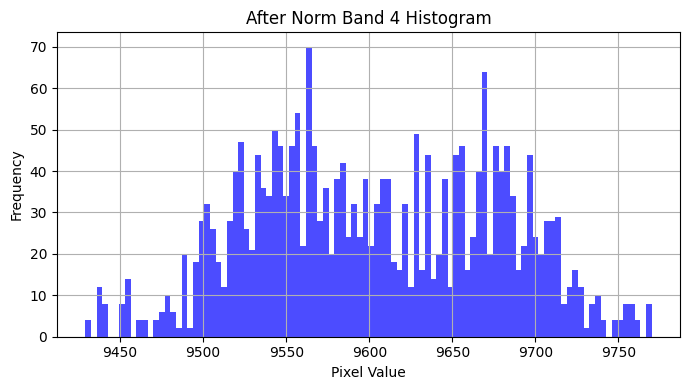

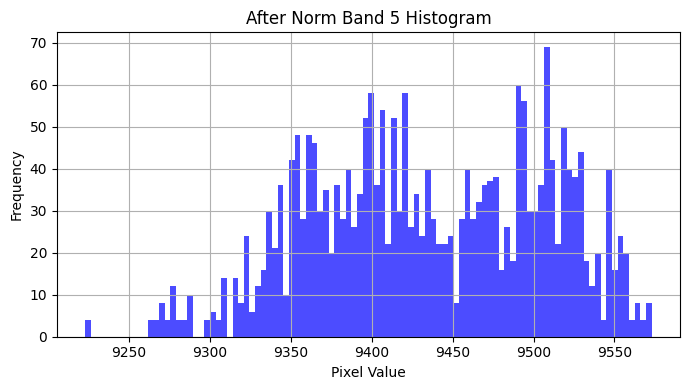

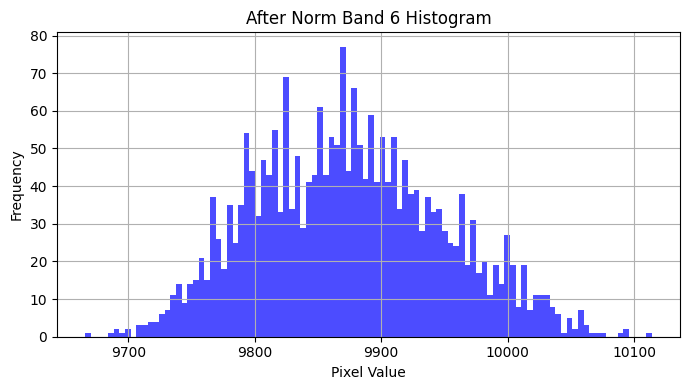

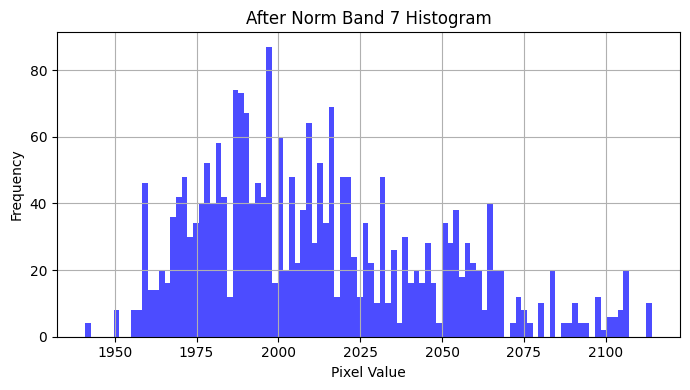

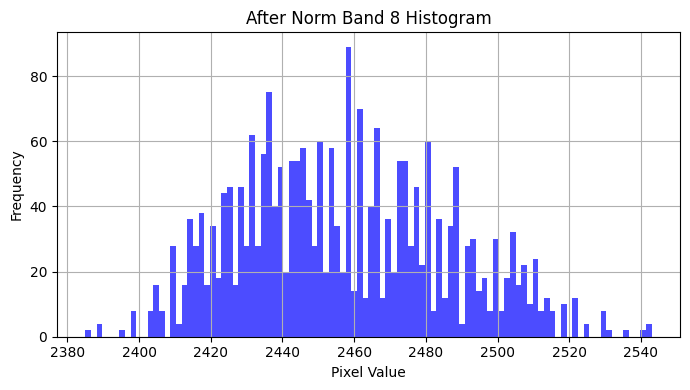

In [52]:
def plot_band_histogram(X, band=0, title_prefix=""):
    """
    Plot histogram for a single band from a (9, H, W) image.
    """
    band_data = X[band].flatten()
    
    plt.figure(figsize=(7, 4))
    plt.hist(band_data, bins=100, color='blue', alpha=0.7)
    plt.title(f"{title_prefix} Band {band} Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def print_band_summary(X, sample_id=0):
    """
    Print stats for each band in a single image (X: shape (9, H, W))
    """
    print(f"\n📦 Sample {sample_id}, Shape: {X.shape}")
    print("Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt")

    for b in range(X.shape[0]):
        band_data = X[b].astype(np.float64).flatten()
        mean = band_data.mean()
        std  = band_data.std()
        vmin = band_data.min()
        vmax = band_data.max()
        p25  = np.percentile(band_data, 25)
        p50  = np.percentile(band_data, 50)
        p75  = np.percentile(band_data, 75)
        sk   = skew(band_data)
        kurt = kurtosis(band_data)

        print(f"{b:>4} | {mean:7.2f} {std:7.2f} {vmin:7.2f} {vmax:7.2f} {p25:7.2f} {p50:7.2f} {p75:7.2f} {sk:7.2f} {kurt:7.2f}")


X, y = all_data[13]
print_band_summary(X, sample_id=0)


X, _ = all_data[13]
for b in range(9):
    plot_band_histogram(X, band=b, title_prefix="After Norm")


In [54]:
#z-score normalistaion
for idx, (X_img, y_img) in enumerate(all_data):
        Xn = X_img.copy()
        for b in range(9):
            Xn[b] = (Xn[b] - means[b]) / stds[b]
        all_data[idx] = (Xn, y_img)




📦 Sample 0, Shape: (9, 48, 48)
Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt
   0 |    1.72    0.02    1.65    1.78    1.70    1.71    1.73    0.23   -0.27
   1 |    1.88    0.02    1.83    1.95    1.87    1.88    1.90    0.24   -0.45
   2 |    1.98    0.02    1.91    2.05    1.96    1.98    2.00    0.01   -0.62
   3 |    2.10    0.02    2.04    2.15    2.08    2.09    2.11    0.02   -0.79
   4 |    2.12    0.03    2.05    2.18    2.10    2.12    2.14    0.03   -0.86
   5 |    2.05    0.03    1.97    2.11    2.03    2.05    2.08   -0.14   -0.84
   6 |    2.14    0.03    2.06    2.24    2.12    2.14    2.16    0.21   -0.42
   7 |   -0.57    0.02   -0.62   -0.50   -0.59   -0.57   -0.56    0.68   -0.16
   8 |    0.16    0.02    0.11    0.23    0.15    0.16    0.18    0.29   -0.54


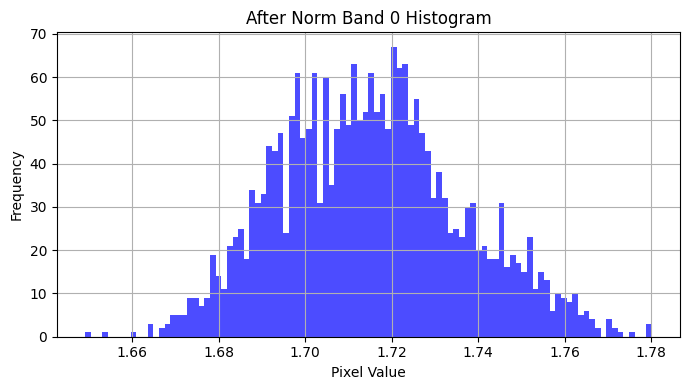

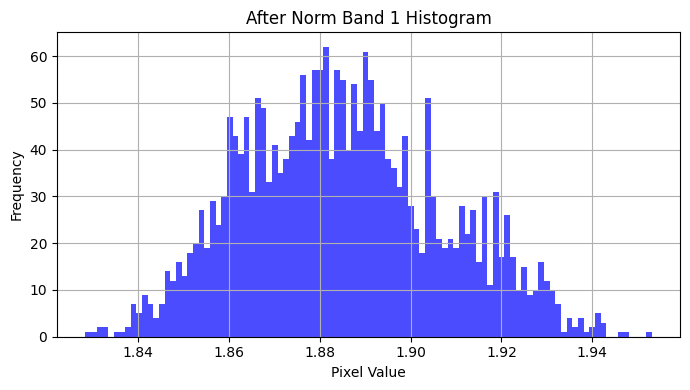

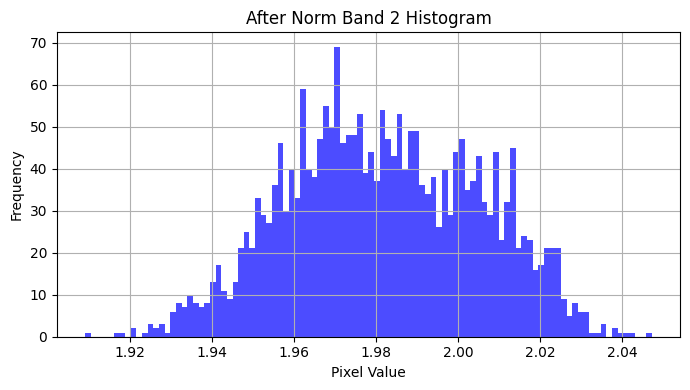

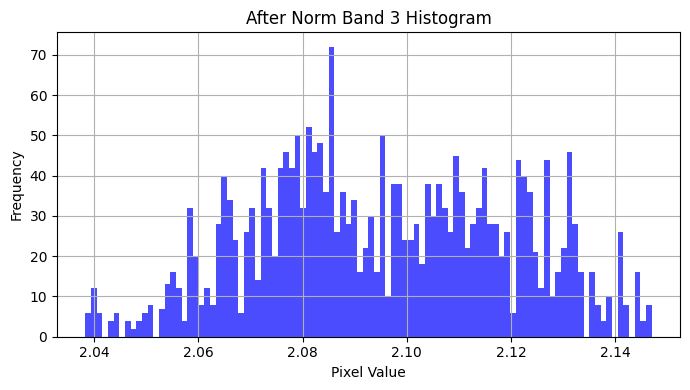

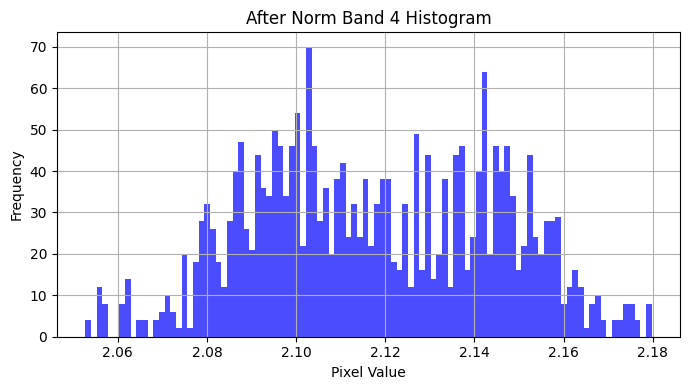

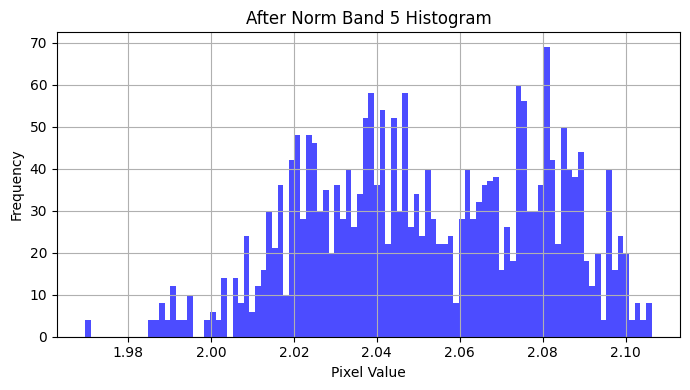

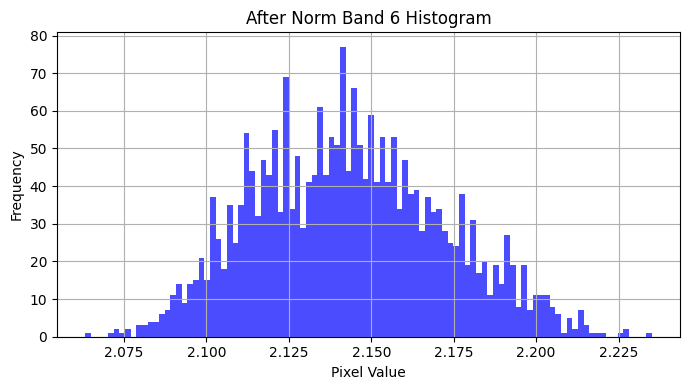

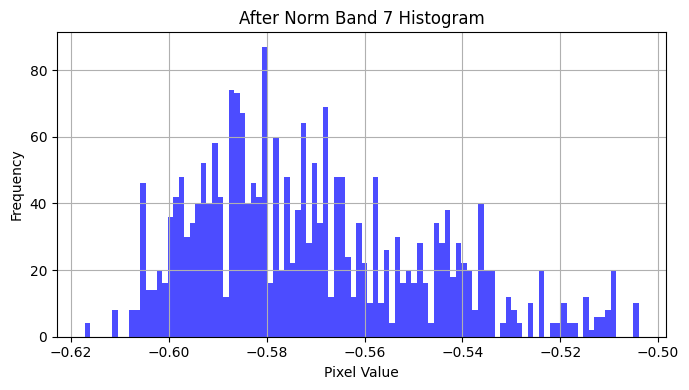

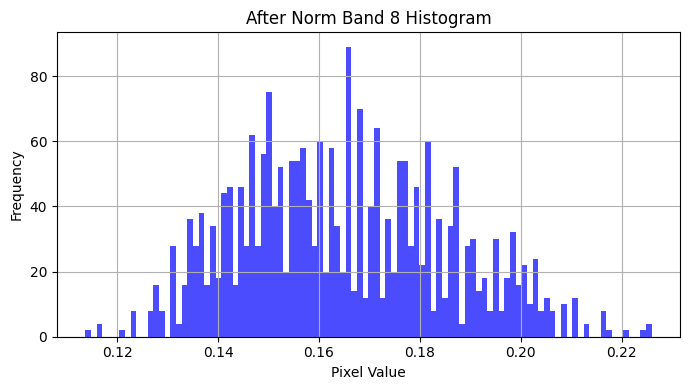

In [55]:
def plot_band_histogram(X, band=0, title_prefix=""):
    """
    Plot histogram for a single band from a (9, H, W) image.
    """
    band_data = X[band].flatten()
    
    plt.figure(figsize=(7, 4))
    plt.hist(band_data, bins=100, color='blue', alpha=0.7)
    plt.title(f"{title_prefix} Band {band} Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def print_band_summary(X, sample_id=0):
    """
    Print stats for each band in a single image (X: shape (9, H, W))
    """
    print(f"\n📦 Sample {sample_id}, Shape: {X.shape}")
    print("Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt")

    for b in range(X.shape[0]):
        band_data = X[b].astype(np.float64).flatten()
        mean = band_data.mean()
        std  = band_data.std()
        vmin = band_data.min()
        vmax = band_data.max()
        p25  = np.percentile(band_data, 25)
        p50  = np.percentile(band_data, 50)
        p75  = np.percentile(band_data, 75)
        sk   = skew(band_data)
        kurt = kurtosis(band_data)

        print(f"{b:>4} | {mean:7.2f} {std:7.2f} {vmin:7.2f} {vmax:7.2f} {p25:7.2f} {p50:7.2f} {p75:7.2f} {sk:7.2f} {kurt:7.2f}")


X, y = all_data[13]
print_band_summary(X, sample_id=0)


X, _ = all_data[13]
for b in range(9):
    plot_band_histogram(X, band=b, title_prefix="After Norm")


In [59]:
label_counter = Counter()

for _, y in all_data:
    flat_labels = y.flatten()
    label_counter.update(flat_labels.tolist())

# Sort the label counts
label_counts = dict(sorted(label_counter.items()))

# ✅ Total number of unique labels
num_labels = len(label_counts)

# ✅ Total number of labeled pixels
total_pixels = sum(label_counts.values())



# 🔍 Print everything
print(f"🔢 Total unique labels: {num_labels}")
print(f"🧮 Total labeled pixels: {total_pixels}")
print("📊 Label Frequencies:")
for label, count in label_counts.items():
    print(f"  Label {label}: {count} pixels : {round(100.0*count/total_pixels,2)}%")

🔢 Total unique labels: 7
🧮 Total labeled pixels: 5529600
📊 Label Frequencies:
  Label 0: 559934 pixels : 10.13%
  Label 1: 389590 pixels : 7.05%
  Label 2: 439496 pixels : 7.95%
  Label 3: 114765 pixels : 2.08%
  Label 4: 2883123 pixels : 52.14%
  Label 5: 705048 pixels : 12.75%
  Label 6: 437644 pixels : 7.91%


In [60]:

label_counter = Counter()

for _, mask in all_data:
    unique, counts = np.unique(mask, return_counts=True)
    label_counter.update(dict(zip(unique, counts)))

print("Class pixel counts:", dict(label_counter))

num_classes = 7
total_pixels = sum(label_counter.values())

weights = []
for cls in range(num_classes):
    cls_count = label_counter.get(cls, 0)
    if cls_count == 0:
        weights.append(0.0)  # Unused class
    else:
        freq = cls_count / total_pixels
        weights.append(1.0 / freq)

# Step 5: Convert to torch.Tensor
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

print("Class weights:", class_weights)


Class pixel counts: {0: 559934, 4: 2883123, 3: 114765, 6: 437644, 5: 705048, 1: 389590, 2: 439496}
Class weights: tensor([ 9.8754, 14.1934, 12.5817, 48.1819,  1.9179,  7.8429, 12.6349],
       device='cuda:0')


In [62]:
#80/20 split
train_data, val_data = train_test_split(
        all_data,
        test_size=0.2,
        random_state=13)

print(f"Total samples: {len(all_data)}")
print(f"Train samples: {len(train_data)}")
print(f"Test samples:  {len(val_data)}")

Total samples: 2400
Train samples: 1920
Test samples:  480


Image sequence shape: (9, 48, 48)
Ground truth shape: (48, 48)


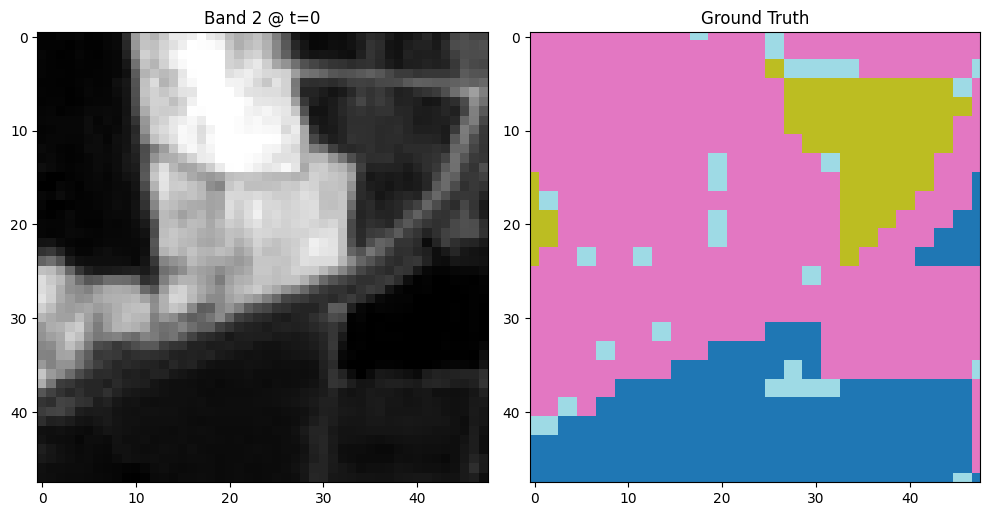

In [65]:
def plot_sample(X, y, timestep=0, band=3):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    img = X[band]
    
    # Normalize visualization range to make contrast visible
    vmin = np.percentile(img, 2)
    vmax = np.percentile(img, 98)

    axs[0].imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    axs[0].set_title(f'Band {band} @ t={timestep}')

    axs[1].imshow(y, cmap='tab20')
    axs[1].set_title('Ground Truth')

    plt.tight_layout()
    plt.show()


# Plot a sample
sample_X, sample_y = all_data[20]
print(f"Image sequence shape: {sample_X.shape}")  # (T, 9, 48, 48)
print(f"Ground truth shape: {sample_y.shape}")    # (48, 48)
plot_sample(sample_X, sample_y, band=2)


# Model

In [ ]:

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.3, dilation=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=dilation, dilation=dilation),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=dilation, dilation=dilation),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.skip = nn.Identity() if in_ch == out_ch else nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        return self.conv(x) + self.skip(x)

class UNet(nn.Module):
    def __init__(self, in_channels=32*9, num_classes=7, base_ch=64, dropout=0.3):
        super().__init__()

        # Encoder path
        self.enc1 = ConvBlock(in_channels, base_ch, dropout)
        self.down1 = nn.Conv2d(base_ch, base_ch*2, kernel_size=3, stride=2, padding=1)  # 48 → 24
        self.enc2 = ConvBlock(base_ch*2, base_ch*2, dropout)
        self.down2 = nn.Conv2d(base_ch*2, base_ch*4, kernel_size=3, stride=2, padding=1)  # 24 → 12
        self.enc3 = ConvBlock(base_ch*4, base_ch*4, dropout)
        self.down3 = nn.Conv2d(base_ch*4, base_ch*8, kernel_size=3, stride=2, padding=1)  # 12 → 6
        self.bottleneck = ConvBlock(base_ch*8, base_ch*8, dropout)

        # Decoder path
        self.up3 = nn.ConvTranspose2d(base_ch*8, base_ch*4, kernel_size=2, stride=2)  # 6 → 12
        self.dec3 = ConvBlock(base_ch*4 + base_ch*4, base_ch*4, dropout)
        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, kernel_size=2, stride=2)  # 12 → 24
        self.dec2 = ConvBlock(base_ch*2 + base_ch*2, base_ch*2, dropout)
        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, kernel_size=2, stride=2)  # 24 → 48
        self.dec1 = ConvBlock(base_ch + base_ch, base_ch, dropout)

        self.final_conv = nn.Conv2d(base_ch, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)      # (B, 64, 48, 48)
        x2 = self.enc2(self.down1(x1))  # (B, 128, 24, 24)
        x3 = self.enc3(self.down2(x2))  # (B, 256, 12, 12)
        xb = self.bottleneck(self.down3(x3))  # (B, 512, 6, 6)

        # Decoder
        x = self.up3(xb)
        x = self.dec3(torch.cat([x, x3], dim=1))
        x = self.up2(x)
        x = self.dec2(torch.cat([x, x2], dim=1))
        x = self.up1(x)
        x = self.dec1(torch.cat([x, x1], dim=1))

        return self.final_conv(x)  # (B, num_classes, 48, 48)


In [68]:
class CNN(nn.Module):
    def __init__(self, in_channels=9, num_classes=7, dropout=0.3):
        super().__init__()

        def res_block(in_ch, out_ch, dilation):
            skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=dilation, dilation=dilation),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(),
                nn.Dropout2d(dropout),
                
                nn.Conv2d(out_ch, out_ch, 3, padding=dilation, dilation=dilation),
                nn.BatchNorm2d(out_ch),
                nn.Dropout2d(dropout),
                nn.ReLU(),
                
                nn.Sequential(skip)  # identity if same shape, otherwise 1x1 conv
            )

        self.encoder1 = res_block(in_channels, 256, dilation=1)
        self.encoder2 = res_block(256, 256, dilation=2)
        self.encoder3 = res_block(256, 256, dilation=4)
        self.encoder4 = res_block(256, 512, dilation=2)
        self.encoder5 = res_block(512, 512, dilation=1)
        self.final_conv = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        # Manual forward pass for residual + skip connections
        def forward_res_block(x, block):
            skip = block[-1][0](x)
            out = block[0](x)
            out = block[1](out)
            out = block[2](out)
            out = block[3](out)
            out = block[4](out)
            out = block[5](out)
            out = block[6](out)
            return F.relu(out + skip)

        x = forward_res_block(x, self.encoder1)
        x = forward_res_block(x, self.encoder2)
        x = forward_res_block(x, self.encoder3)
        x = forward_res_block(x, self.encoder4)
        x = forward_res_block(x, self.encoder5)
        return self.final_conv(x)


In [71]:


class CustomDataset(Dataset):
    def __init__(self, tiles, label_smoothing=0.1, num_classes=7, augment=False, noise_std=0.01):
        """
        tiles: list of (X, y) where X: (9, H, W), y: (H, W)
        """
        self.tiles = tiles
        self.augment = augment
        self.label_smoothing = label_smoothing
        self.num_classes = num_classes
        self.noise_std = noise_std

        # geometric augmentations
        self.aug = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(15, interpolation=InterpolationMode.BILINEAR),
        ])

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        X, y = self.tiles[idx]
        # X: (9, H, W) → torch.Tensor
        X = torch.from_numpy(X).float().clone()
        # y: (H, W) → torch.LongTensor
        y = torch.from_numpy(y).long().clone()

        if self.augment:
            seed = random.randint(0, 2**32 - 1)
            torch.manual_seed(seed)
            X = self.aug(X)
            torch.manual_seed(seed)
            y = self.aug(y.unsqueeze(0)).squeeze(0).long()

        # gaussian noise
        X = X + torch.randn_like(X) * self.noise_std

        return X, y


In [72]:
def get_dataloaders(train_tiles, val_tiles, batch_size=16, num_workers=2, pin_memory=True):
    """
    No timesteps slicing anymore.
    """
    train_ds = CustomDataset(train_tiles,  augment=True)
    val_ds   = CustomDataset(val_tiles,    augment=False)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=pin_memory
    )
    val_loader = DataLoader(
        val_ds,   batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin_memory
    )
    return train_loader, val_loader


# Training

In [74]:
# --- HYPERPARAMS & SETUP ---
num_epochs      = 20
lr              = 1e-3
weight_decay    = 1e-4
label_smoothing = 0.1
batch_size      = 16

# dataloaders
train_loader, val_loader = get_dataloaders(train_data, val_data, batch_size=batch_size)

# model: now in_channels=9
model     = CNN(in_channels=9, num_classes=7).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss(weight = class_weights,label_smoothing=label_smoothing)

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

# --- TRAINING LOOP ---
for epoch in range(num_epochs):
    # train
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for X, y in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)            # expect logits.shape = (B, 7, H, W)
        loss   = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct   += (preds == y).sum().item()
        total     += y.numel()

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(100 * correct / total)

    # validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X, y in tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}", leave=False):
            X, y    = X.to(device), y.to(device)
            logits  = model(X)
            loss    = criterion(logits, y)
            val_loss    += loss.item()
            preds       = logits.argmax(dim=1)
            val_correct += (preds == y).sum().item()
            val_total   += y.numel()

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(100 * val_correct / val_total)
    scheduler.step()

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
        f"Train Acc: {train_accs[-1]:.2f}% | Val Acc: {val_accs[-1]:.2f}%"
    )


[Train] Epoch 1/20: 100%|██████████| 120/120 [00:33<00:00,  3.59it/s]


Epoch 01 | Train Loss: 2.1629 | Val Loss: 2.1137 | Train Acc: 15.78% | Val Acc: 24.71%


[Train] Epoch 2/20: 100%|██████████| 120/120 [00:32<00:00,  3.71it/s]


Epoch 02 | Train Loss: 2.0246 | Val Loss: 2.1277 | Train Acc: 19.28% | Val Acc: 22.40%


[Train] Epoch 3/20: 100%|██████████| 120/120 [00:32<00:00,  3.72it/s]


Epoch 03 | Train Loss: 1.9943 | Val Loss: 2.1117 | Train Acc: 19.86% | Val Acc: 19.62%


[Train] Epoch 4/20: 100%|██████████| 120/120 [00:32<00:00,  3.71it/s]


Epoch 04 | Train Loss: 1.9780 | Val Loss: 2.0716 | Train Acc: 21.87% | Val Acc: 25.35%


[Train] Epoch 5/20: 100%|██████████| 120/120 [00:32<00:00,  3.71it/s]


Epoch 05 | Train Loss: 1.9658 | Val Loss: 2.0946 | Train Acc: 21.71% | Val Acc: 22.69%


[Train] Epoch 6/20: 100%|██████████| 120/120 [00:32<00:00,  3.71it/s]


Epoch 06 | Train Loss: 1.9300 | Val Loss: 2.0157 | Train Acc: 24.46% | Val Acc: 24.62%


[Train] Epoch 7/20: 100%|██████████| 120/120 [00:32<00:00,  3.71it/s]


Epoch 07 | Train Loss: 1.8969 | Val Loss: 2.0179 | Train Acc: 25.46% | Val Acc: 19.71%


[Train] Epoch 8/20: 100%|██████████| 120/120 [00:32<00:00,  3.71it/s]


Epoch 08 | Train Loss: 1.9087 | Val Loss: 2.0323 | Train Acc: 25.32% | Val Acc: 18.67%


[Train] Epoch 9/20: 100%|██████████| 120/120 [00:32<00:00,  3.71it/s]


Epoch 09 | Train Loss: 1.8893 | Val Loss: 1.9959 | Train Acc: 25.93% | Val Acc: 21.03%


[Train] Epoch 10/20: 100%|██████████| 120/120 [00:32<00:00,  3.71it/s]


Epoch 10 | Train Loss: 1.8815 | Val Loss: 1.9755 | Train Acc: 25.85% | Val Acc: 23.31%


[Train] Epoch 11/20: 100%|██████████| 120/120 [00:32<00:00,  3.71it/s]


Epoch 11 | Train Loss: 1.8562 | Val Loss: 1.9473 | Train Acc: 27.64% | Val Acc: 24.23%


[Train] Epoch 12/20:  88%|████████▊ | 106/120 [00:28<00:03,  3.68it/s]


KeyboardInterrupt: 

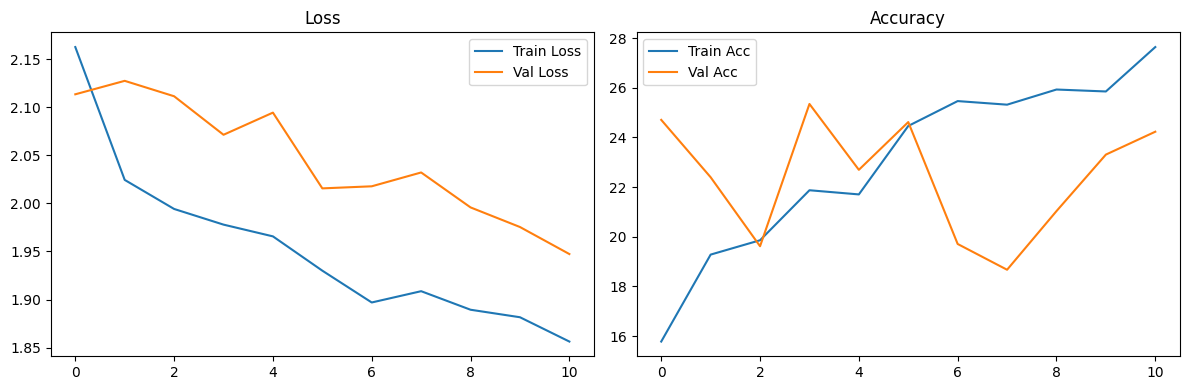

In [75]:
# --- Plotting ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evalutaion

In [78]:
def visualize(model, dataset, idx=0, num_classes=7, label_names=None, rgb_bands=(2, 1, 0), timestep=16):
    model.eval()

    # === Load data ===
    X, y = dataset[idx]           # X: (C*T, H, W), y: (H, W)
    X_input = X.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(X_input).argmax(1).squeeze().cpu().numpy()

    y = y.numpy()

    # === Reshape for RGB ===
    C = 9
    T = X.shape[0] // C
    H, W = X.shape[1], X.shape[2]

    X_vis = X.view(T, C, H, W)  # (T, C, H, W)
    rgb = X_vis[timestep][list(rgb_bands)].numpy()
    rgb = np.transpose(rgb, (1, 2, 0))
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)  # normalize

    # === Color Map and Legend ===
    cmap = plt.cm.get_cmap('tab10', num_classes)
    pred_classes = np.unique(pred)
    gt_classes = np.unique(y)

    pred_legend = [mpatches.Patch(color=cmap(cls), label=label_names[cls]) for cls in pred_classes] if label_names else []
    gt_legend = [mpatches.Patch(color=cmap(cls), label=label_names[cls]) for cls in gt_classes] if label_names else []

    # === Plotting ===
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Top row: Pred and GT
    axs[0, 0].imshow(pred, cmap=cmap, vmin=0, vmax=num_classes-1)
    axs[0, 0].set_title("Predicted")
    axs[0, 0].axis("off")
    if pred_legend:
        axs[0, 0].legend(handles=pred_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

    axs[0, 1].imshow(y, cmap=cmap, vmin=0, vmax=num_classes-1)
    axs[0, 1].set_title("Ground Truth")
    axs[0, 1].axis("off")
    if gt_legend:
        axs[0, 1].legend(handles=gt_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Bottom left: Satellite RGB
    axs[1, 0].imshow(rgb)
    axs[1, 0].set_title(f"Satellite RGB @ timestep {timestep}")
    axs[1, 0].axis("off")

    # Bottom right: hide unused
    axs[1, 1].axis("off")

    plt.tight_layout()
    plt.show()



def evaluate_combined(model, loader, label_names, num_classes=7):
    model.eval()
    pred_counts = np.zeros(num_classes, dtype=int)
    gt_counts = np.zeros(num_classes, dtype=int)
    correct = 0
    total = 0

    with torch.no_grad():
        print(f"🔍 Evaluating {len(loader.dataset)} samples")
        for X, y in loader:
            X, y = X.to(device), y.to(device)  # X: (B, 288, 48, 48), y: (B, 48, 48)
            preds = model(X).argmax(1)        # (B, 48, 48)

            preds_np = preds.cpu().numpy().flatten()
            y_np = y.cpu().numpy().flatten()

            for cls in range(num_classes):
                pred_counts[cls] += np.sum(preds_np == cls)
                gt_counts[cls] += np.sum(y_np == cls)

            correct += np.sum(preds_np == y_np)
            total += y_np.size

    print("\n📊 Ground Truth Pixel Count Per Class (Total):")
    for cls in range(num_classes):
        print(f"  {label_names[cls]}: {gt_counts[cls]}")

    print("\n🤖 Predicted Pixel Count Per Class (Total):")
    for cls in range(num_classes):
        print(f"  {label_names[cls]}: {pred_counts[cls]}")

    acc = correct / total
    print(f"\n✅ Per-pixel Accuracy (Total): {acc:.4f}")

    # === Plotting the distributions ===
    class_names = [label_names[cls] for cls in range(num_classes)]

    plt.figure(figsize=(10, 5))
    bar_width = 0.35
    x = np.arange(num_classes)

    plt.bar(x - bar_width/2, gt_counts, bar_width, label='Ground Truth', color='skyblue')
    plt.bar(x + bar_width/2, pred_counts, bar_width, label='Predicted', color='salmon')

    plt.xlabel("Classes")
    plt.ylabel("Pixel Count")
    plt.title("Pixel Distribution per Class")
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

label_names = {
    0: "Cereals",
    1: "Maize",
    2: "Rice",
    3: "Forage",
    4: "Unknown crop",
    5: "Woods/tree crops",
    6: "Non-agricultural"
}


visualize(model, val_data, idx=8, num_classes=7, label_names=label_names,timestep = 16)





AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [ ]:

def evaluate_combined(model, loader, label_names, num_classes=7):
    model.eval()
    pred_counts = np.zeros(num_classes, dtype=int)
    gt_counts = np.zeros(num_classes, dtype=int)
    correct = 0
    total = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        print(f"🔍 Evaluating {len(loader.dataset)} samples")
        for X, y in loader:
            X, y = X.to(device), y.to(device)  # X: (B, 288, 48, 48), y: (B, 48, 48)
            preds = model(X).argmax(1)         # (B, 48, 48)

            preds_np = preds.cpu().numpy().flatten()
            y_np = y.cpu().numpy().flatten()

            all_preds.extend(preds_np)
            all_targets.extend(y_np)

            for cls in range(num_classes):
                pred_counts[cls] += np.sum(preds_np == cls)
                gt_counts[cls] += np.sum(y_np == cls)

            correct += np.sum(preds_np == y_np)
            total += y_np.size

    acc = correct / total

    print("\n📊 Ground Truth Pixel Count Per Class (Total):")
    for cls in range(num_classes):
        print(f"  {label_names[cls]}: {gt_counts[cls]}")

    print("\n🤖 Predicted Pixel Count Per Class (Total):")
    for cls in range(num_classes):
        print(f"  {label_names[cls]}: {pred_counts[cls]}")

    print(f"\n✅ Per-pixel Accuracy (Total): {acc:.4f}")

    # === Confusion Matrix ===
    conf_mat = confusion_matrix(all_targets, all_preds, labels=np.arange(num_classes))
    print("\n🧩 Confusion Matrix:")
    print(conf_mat)

    # === Per-Class IoU and mIoU ===
    ious = []
    for cls in range(num_classes):
        TP = conf_mat[cls, cls]
        FP = conf_mat[:, cls].sum() - TP
        FN = conf_mat[cls, :].sum() - TP
        denom = TP + FP + FN
        iou = TP / denom if denom != 0 else float('nan')
        ious.append(iou)
        print(f"📦 IoU for {label_names[cls]}: {iou:.4f}")
    
    mean_iou = np.nanmean(ious)
    print(f"\n📐 Mean IoU (mIoU): {mean_iou:.4f}")

    # === Per-class F1 Scores ===
    f1s = f1_score(all_targets, all_preds, labels=np.arange(num_classes), average=None, zero_division=0)
    for cls in range(num_classes):
        print(f"🎯 F1 Score for {label_names[cls]}: {f1s[cls]:.4f}")

    macro_f1 = f1_score(all_targets, all_preds, labels=np.arange(num_classes), average='macro', zero_division=0)
    print(f"\n🎯 Macro F1 Score: {macro_f1:.4f}")

    # === Plot class distribution ===
    class_names = [label_names[cls] for cls in range(num_classes)]

    plt.figure(figsize=(10, 5))
    bar_width = 0.35
    x = np.arange(num_classes)

    plt.bar(x - bar_width/2, gt_counts, bar_width, label='Ground Truth', color='skyblue')
    plt.bar(x + bar_width/2, pred_counts, bar_width, label='Predicted', color='salmon')

    plt.xlabel("Classes")
    plt.ylabel("Pixel Count")
    plt.title("Pixel Distribution per Class")
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # === Confusion Matrix Heatmap ===
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()



evaluate_combined(model, val_loader, label_names, num_classes=7)

# Loading Model

In [ ]:
epoch = 10
model.load_state_dict(torch.load(f"model_epoch_{epoch}.pth"))
model.to(device)
